In [11]:
# cell 1
import sys
import os

# Set up the path to include the src directory
sys.path.append(os.path.abspath('..'))


%load_ext autoreload
%autoreload 2

# Import our custom modules
from src.utils import get_spark_session
from src.config import API_KEY, BASE_URL, MOVIE_IDS
from src.ingestion import fetch_movie_data
from src.cleaning import clean_movie_data
from src.analysis import get_ranked_movies, analyze_franchises
from src.visualization import (
    plot_yearly_trends, 
    plot_genre_roi, 
    plot_revenue_vs_budget, 
    plot_franchise_comparison, 
    plot_popularity_vs_rating
)

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize Spark
spark = get_spark_session("TMDB_Analysis_Lab")
print(f"Spark Version: {spark.version}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Spark Version: 3.5.0


In [12]:
# cell 2
# 1. Fetch raw data using Python (Driver Node)
print(f"Fetching data for {len(MOVIE_IDS)} movies...")
raw_data_list = fetch_movie_data(MOVIE_IDS, API_KEY, BASE_URL)

# 2. Convert to Spark DataFrame
# Spark automatically infers the schema from the list of dicts
df_raw = spark.createDataFrame(raw_data_list)

print("Raw Schema:")
df_raw.printSchema()

Fetching data for 19 movies...
Fetching 1/19: ID 0...
Fetching 2/19: ID 299534...
Fetching 3/19: ID 19995...
Fetching 4/19: ID 140607...
Fetching 5/19: ID 299536...
Fetching 6/19: ID 597...
Fetching 7/19: ID 135397...
Fetching 8/19: ID 420818...
Fetching 9/19: ID 24428...
Fetching 10/19: ID 168259...
Fetching 11/19: ID 99861...
Fetching 12/19: ID 284054...
Fetching 13/19: ID 12445...
Fetching 14/19: ID 181808...
Fetching 15/19: ID 330457...
Fetching 16/19: ID 351286...
Fetching 17/19: ID 109445...
Fetching 18/19: ID 321612...
Fetching 19/19: ID 260513...
Raw Schema:
root
 |-- adult: boolean (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- belongs_to_collection: map (nullable = true)
 |    |-- key: string
 |    |-- value: long (valueContainsNull = true)
 |-- budget: long (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: map (containsNull = true)
 |    |    |-- key: string
 |    |    |-- value: long (valueContainsNull = true)
 |-- homepage: stri

In [13]:
# cell 3
# Apply our Spark cleaning pipeline
df_clean = clean_movie_data(df_raw)

# Cache the result since we will use this dataframe for multiple analyses
df_clean.cache()

print(f"Cleaned Row Count: {df_clean.count()}")
df_clean.select("title", "release_date", "revenue_musd", "roi").show(5, truncate=False)

Cleaned Row Count: 18
+----------------------------+------------+------------+-----------------+
|title                       |release_date|revenue_musd|roi              |
+----------------------------+------------+------------+-----------------+
|Avengers: Endgame           |2019-04-24  |2799.4391   |7.86359297752809 |
|Avatar                      |2009-12-16  |2923.706026 |12.33631234599156|
|Star Wars: The Force Awakens|2015-12-15  |2068.223624 |8.441729077551022|
|Avengers: Infinity War      |2018-04-25  |2052.415039 |6.841383463333333|
|Titanic                     |1997-11-18  |2264.162353 |11.320811765     |
+----------------------------+------------+------------+-----------------+
only showing top 5 rows



In [14]:
# cell 4
print("--- Top 5 Highest Revenue ---")
top_rev = get_ranked_movies(df_clean, "revenue_musd", ascending=False)
top_rev.select("title", "revenue_musd", "budget_musd").show()

print("--- Top 5 Highest ROI ---")
top_roi = get_ranked_movies(df_clean, "roi", ascending=False)
top_roi.select("title", "roi", "revenue_musd").show()

print("--- Worst 5 Flops (Lowest ROI) ---")
# Filter for significant budget first to avoid divide-by-zero anomalies on micro-films
flop_roi = get_ranked_movies(df_clean.filter("budget_musd > 10"), "roi", ascending=True)
flop_roi.select("title", "roi", "budget_musd", "revenue_musd").show()

--- Top 5 Highest Revenue ---
+--------------------+------------+-----------+
|               title|revenue_musd|budget_musd|
+--------------------+------------+-----------+
|              Avatar| 2923.706026|      237.0|
|   Avengers: Endgame|   2799.4391|      356.0|
|             Titanic| 2264.162353|      200.0|
|Star Wars: The Fo...| 2068.223624|      245.0|
|Avengers: Infinit...| 2052.415039|      300.0|
+--------------------+------------+-----------+

--- Top 5 Highest ROI ---
+--------------------+-----------------+------------+
|               title|              roi|revenue_musd|
+--------------------+-----------------+------------+
|              Avatar|12.33631234599156| 2923.706026|
|             Titanic|     11.320811765| 2264.162353|
|      Jurassic World|      11.14358296| 1671.537444|
|Harry Potter and ...|     10.732089752| 1341.511219|
|           Frozen II|9.691223173333332| 1453.683476|
+--------------------+-----------------+------------+

--- Worst 5 Flops (Lowes

In [15]:
# cell 5
# Compare Franchises vs Standalone
franchise_stats = analyze_franchises(df_clean)

# Collect to Pandas for display
pdf_franchise = franchise_stats.toPandas()
display(pdf_franchise)

,is_franchise,count,avg_revenue,median_roi,avg_budget,avg_popularity,avg_rating
0,False,18,1691.831828,7.888409,213.777778,25.066233,7.396333


In [17]:
# Cell 6: Data Preparation for Visualizations
from pyspark.sql.functions import year, explode, split, col, median, mean, count
import pyspark.sql.functions as F  # <--- FIX: This import was missing

# 1. Prepare Yearly Trends Data
# Extract year from release_date and aggregate
df_yearly = df_clean.withColumn("year", year("release_date")) \
    .groupBy("year") \
    .agg(
        count("id").alias("movie_count"),
        mean("revenue_musd").alias("mean_revenue"),
        mean("budget_musd").alias("mean_budget"),
        mean("roi").alias("mean_roi")
    ).orderBy("year")

# 2. Prepare Genre Data (Explode the 'A|B|C' string into separate rows)
df_genre = df_clean.withColumn("genre", explode(split("genres", "\|"))) \
    .groupBy("genre") \
    .agg(median("roi").alias("median_roi")) \
    .orderBy(col("median_roi").desc())

# 3. Prepare Scatter Plot Data (Individual Movies)
df_scatter = df_clean.select("title", "budget_musd", "revenue_musd", "popularity", "vote_average")

# 4. Prepare Franchise Data
df_franchise = df_clean.withColumn("type", 
                                   F.when(col("belongs_to_collection").isNotNull(), "Franchise")
                                   .otherwise("Standalone")) \
    .groupBy("type") \
    .agg(
        mean("revenue_musd").alias("mean_revenue"),
        mean("budget_musd").alias("mean_budget"),
        mean("roi").alias("mean_roi"),
        mean("vote_average").alias("mean_rating")
    )

# --- Collect all to Pandas ---
# These variables (pdf_...) will be passed to your visualization functions next
pdf_yearly = df_yearly.toPandas()
pdf_genre = df_genre.toPandas()
pdf_scatter = df_scatter.toPandas()
pdf_franchise = df_franchise.toPandas()

print("Data ready for visualization!")

Data ready for visualization!


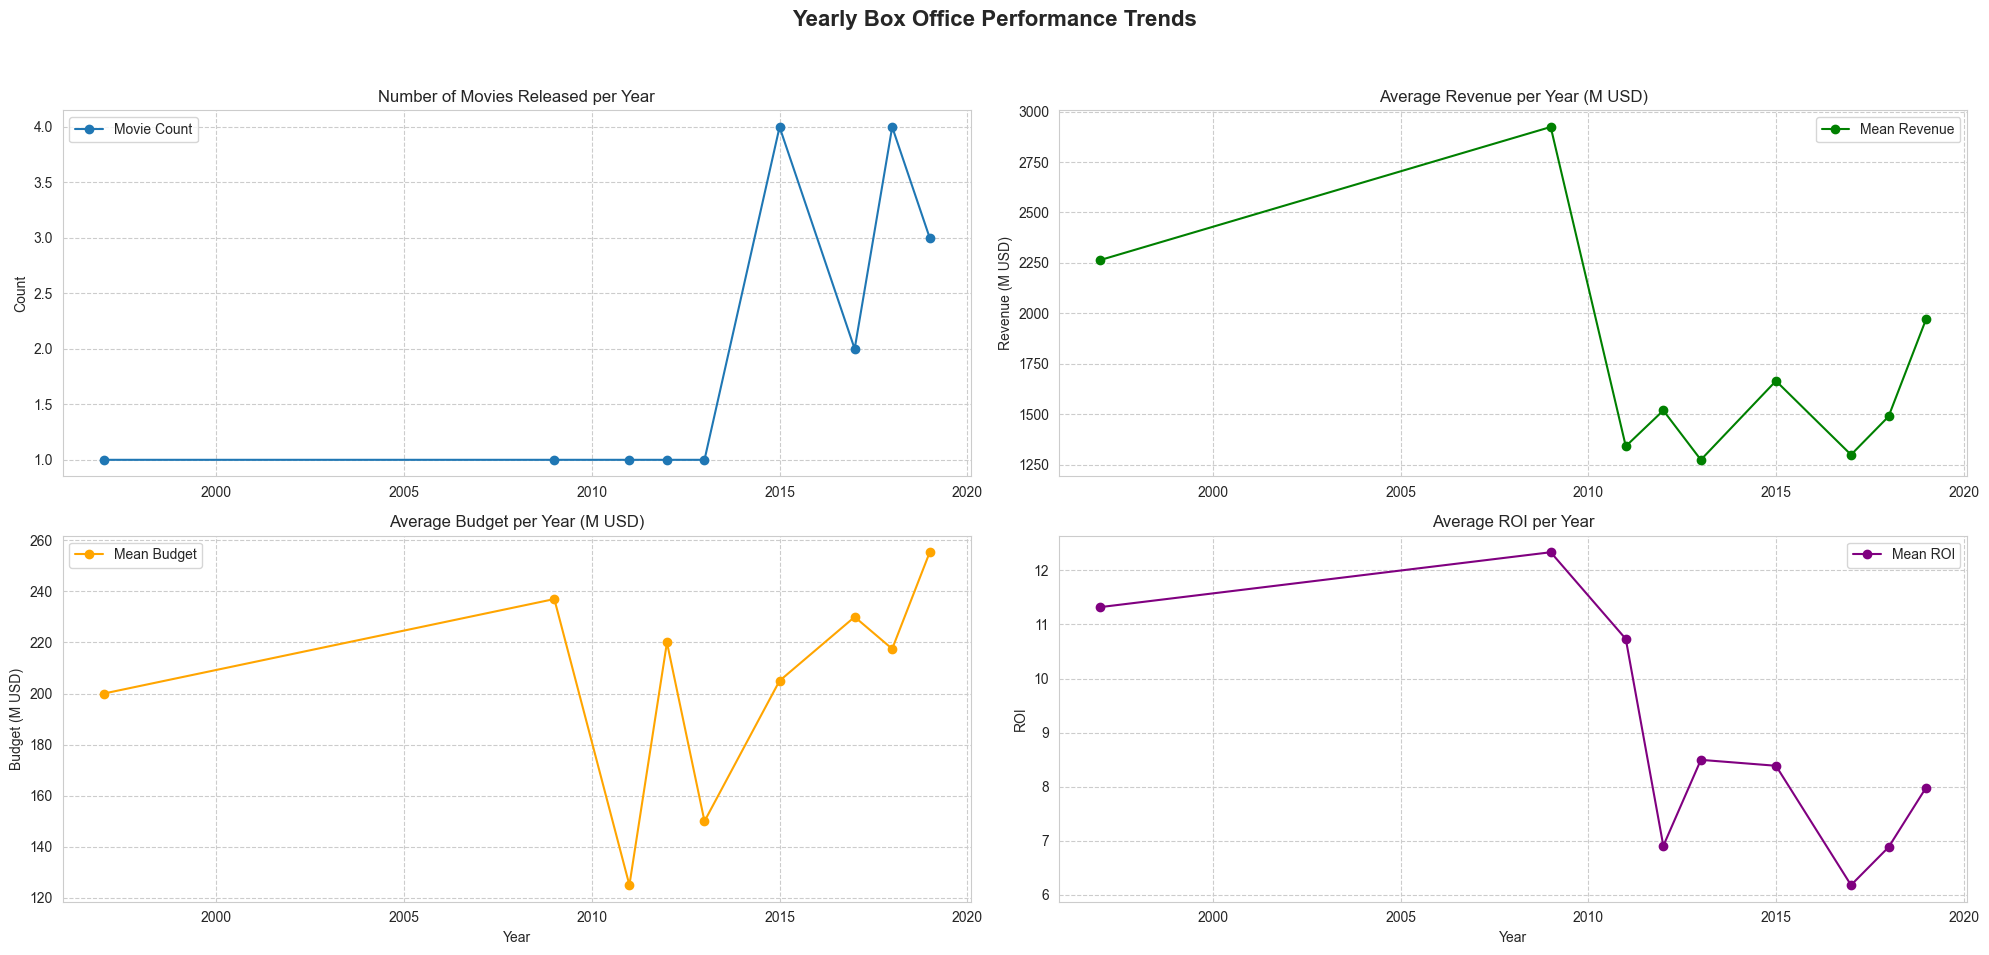

In [18]:
# Cell 7
plot_yearly_trends(pdf_yearly)

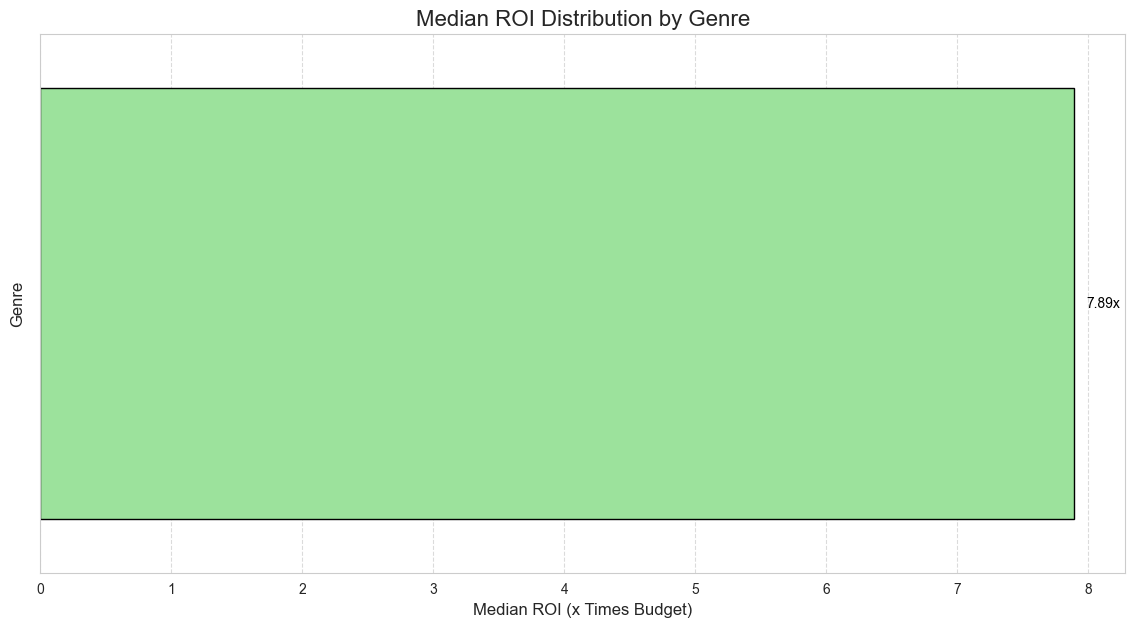

In [19]:
# Cell 8
plot_genre_roi(pdf_genre)

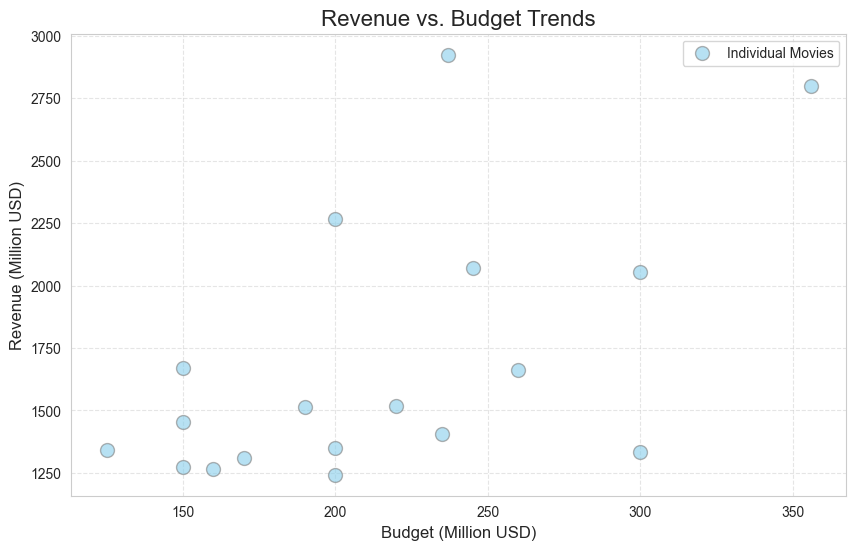

In [20]:
# Cell 9
plot_revenue_vs_budget(pdf_scatter)

c:\Users\CourageDei\Desktop\Moodle\DE\DE05\Module Lab 1- TMDB Movie Data Analysis using Pandas and APIs\src\visualization.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf_franchise, x='type', y=y_col, ax=ax, palette=['#2b8cbe', '#a53e74'], edgecolor='black')
c:\Users\CourageDei\Desktop\Moodle\DE\DE05\Module Lab 1- TMDB Movie Data Analysis using Pandas and APIs\src\visualization.py:86: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(data=pdf_franchise, x='type', y=y_col, ax=ax, palette=['#2b8cbe', '#a53e74'], edgecolor='black')
c:\Users\CourageDei\Desktop\Moodle\DE\DE05\Module Lab 1- TMDB Movie Data Analysis using Pandas and APIs\src\visualization.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign th

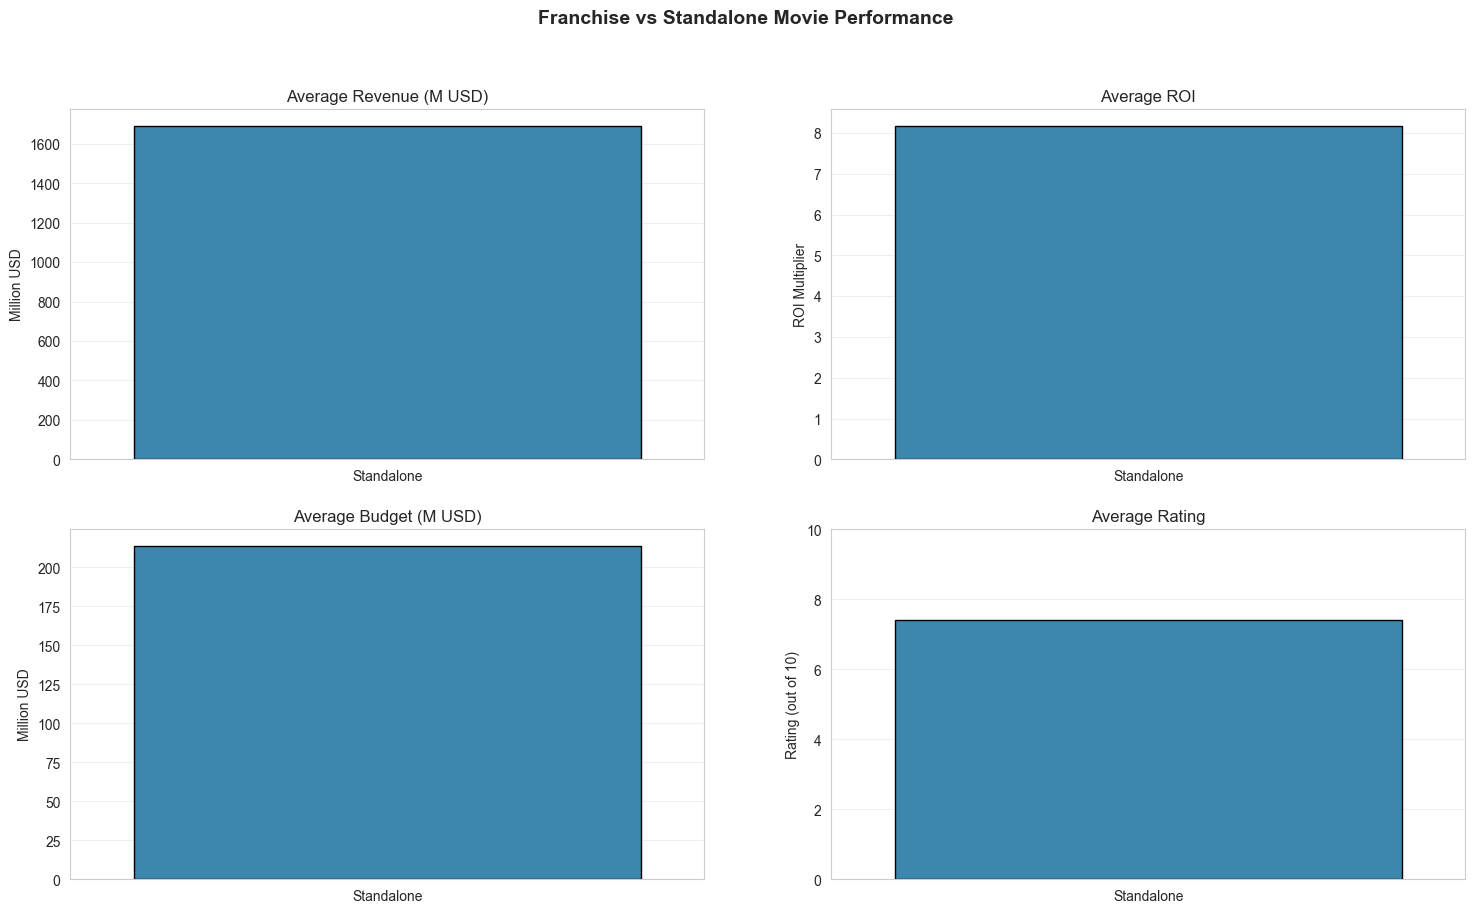

In [21]:
# Cell 10
plot_franchise_comparison(pdf_franchise)

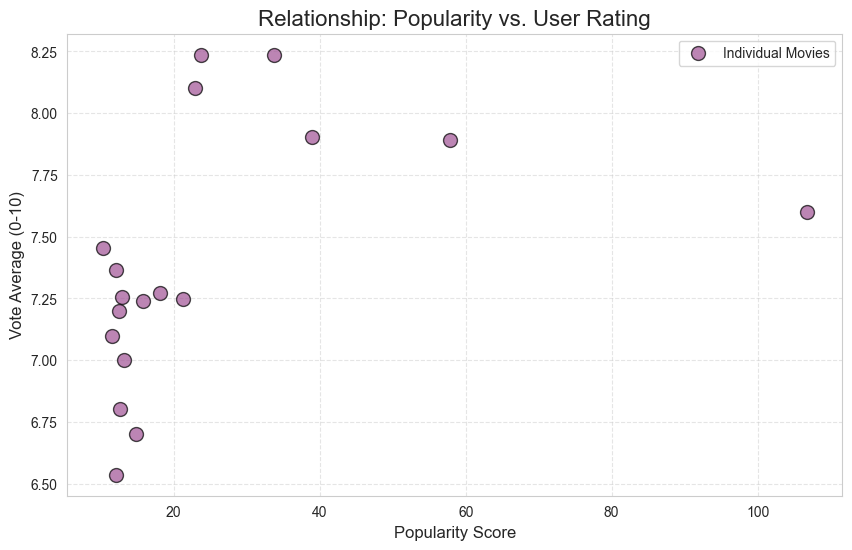

In [22]:
# Cell 11
plot_popularity_vs_rating(pdf_scatter)